In [7]:
from PIL import Image, ImageStat
from PIL.ImageDraw import ImageDraw

import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

from random import randint
from math import pi

import os
from os import path

from fastai import vision
from fastai.vision import ImageList, FloatList, cnn_learner, pil2tensor, open_image
from fastai.callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, CSVLogger
from fastai.train import ShowGraph, Learner
from fastai.metrics import mean_absolute_error, mean_squared_error
from torchvision import models
from torch import nn
import numpy as np

from functools import partial

## Local Imports ##
from models import helpers, models
from datasets import helpers


## Funcoes Auxiliares

### Model Helpers

In [3]:
def base_layer(conv_args, pool_layer, pool_size, activation_fn):
    return nn.Sequential(nn.Conv2d(**conv_args), pool_layer(pool_size), activation_fn())
        


def base_model(max_channels, activation_fn, pool_layer, pool_size, num_layers, conv_stride=1):
    return nn.Sequential(
        *[base_layer({
            "in_channels": i if i < max_channels else max_channels, 
            "out_channels": abs(i+1) if i < max_channels else max_channels,
            "kernel_size": 3,
            "stride": conv_stride
            }, pool_layer, pool_size, activation_fn) for i in range(1, num_layers//2 + 1)],
        *[base_layer({
            "in_channels": i if i < max_channels else max_channels,
            "out_channels": i - 1 if i - 1 < max_channels else max_channels,
            "kernel_size": 3,
            "stride": conv_stride 
        }, pool_layer, pool_size, activation_fn) for i in range(num_layers//2 + 1, 1, -1)]
    )



class SumPool2d(nn.Module):
    def __init__(self, pool_size):
        super(SumPool2d, self).__init__()
        self.pool_size = pool_size
        self.area = pool_size * pool_size
        
    def forward(self, x):
        return F.avg_pool2d(x, self.pool_size) * self.area

### Dataset Generation Helpers

In [4]:
def random_point(w, h, minx=0, miny=0):
    x, y = randint(minx, w), randint(miny, h)
    return (x, y)

def area_ellipse(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    x_len = abs(x1 - x2)
    y_len = abs(y1 - y2)
    return pi * x_len * y_len

def gen_example(w, h, num_polygons=1, count=False):
    example = Image.new('1', (w, h))
    draw = ImageDraw(example, mode='1')

    total_area = w * h
    area = 0
    for i in range(num_polygons):
        p1 = random_point(w, h)
        p2 = random_point(w, h, p1[0], p1[1])
        draw.rectangle([p1, p2], fill=1)

    (area, ) = ImageStat.Stat(example).sum
    if not count:
        area /= total_area
    return (example, area)

def gen_df(
        root_dir, 
        dt_len, 
        img_size=(512, 512), 
        skip=True, 
        test=False, 
        count=False):
    root_dir = path.abspath(root_dir)
    root_dir = path.join(root_dir, "test" if test else "train")
    img_dir = path.join(root_dir, 'images')
    df_dest = path.join(root_dir, 'data.csv')
    if path.exists(df_dest) and skip:
        print("Found existing dataset, skipping...")
        return pd.read_csv(df_dest, index_col=0)
    
    for directory in [root_dir, img_dir]:
        if not path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory {directory}")

    df = pd.DataFrame(columns=['filename', 'area'])
    for i in range(dt_len):
        filename = f"img_{i}.jpeg"
        dest_path = path.join(img_dir, filename)
        img, area = gen_example(*img_size, count=count)
        img.save(dest_path)
        row = pd.Series({"filename": filename, "area": area})
        df.loc[i] = row

    df.to_csv(df_dest)
    return df

### Results Helpers

In [5]:
def summarize_results(models, root_dir, order_by="mean_absolute_error"):
    df_results = pd.DataFrame()
    for model in models:
        name = model["name"]
        df_path = f"{root_dir}/{name}/history_{name}.csv"
        df = pd.read_csv(df_path, index_col=0)
        max_acc_thresh = df.iloc[df[order_by].idxmax()]
        max_idx = max_acc_thresh.name
        max_acc_thresh = max_acc_thresh.append(
            pd.Series({"name": name, "epoch": max_idx})
        )
        df_results = df_results.append(max_acc_thresh, ignore_index=True)

    df_results = df_results[['name', 'epoch', order_by, 'valid_loss', 'train_loss']]
    dest_file = f"{root_dir}/summary"
    
    print(f"Saving to {dest_file}")
    df_results.to_csv(dest_file)

def save_stats(learn, name):
    p = learn.recorder.plot_losses(return_fig=True)
    p.savefig(path.join(learn.path, 'losses'))

## Dataset

In [16]:
DT_LEN = 25000
COUNT = True
ROOT_DIR = 'data'
DT_ROOT_DIR = 'polygon_data_counts' if COUNT else 'polygon_data'
DT_ROOT_DIR = path.join(ROOT_DIR, DT_ROOT_DIR)
DT_ROOT_DIR = path.abspath(DT_ROOT_DIR)
MODEL_ROOT_DIR = path.join(DT_ROOT_DIR, 'results')
W, H = 512, 512
BATCH_SIZE = 64

DATASETS = [
        {"root_dir": path.join(ROOT_DIR, "polygon_data_counts"), "count": True},
        {"root_dir": path.join(ROOT_DIR, "polygon_data_percentage"), "count": False}
    ]

for dataset in DATASETS:
    df_train = gen_df(dataset["root_dir"], DT_LEN, skip=True, test=False, count=dataset["count"])
    df_test  = gen_df(dataset["root_dir"], DT_LEN, skip=True, test=True, count=dataset["count"])

/home/victor/Git/areacnn/data/polygon_data_counts
Found existing dataset, skipping...
Found existing dataset, skipping...
Found existing dataset, skipping...
Found existing dataset, skipping...


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

test_item_list = (ImageList
    .from_df(path=path.join(DT_ROOT_DIR, 'test', 'images'), df=df_test, convert_mode='1')
)
    
bunch = (ImageList
            .from_df(path=path.join(DT_ROOT_DIR, 'train', 'images'), df=df_train, convert_mode='1')
            .split_by_rand_pct()
            .label_from_df(cols=1, label_cls=FloatList)
            .transform(size=(W, H))
            .add_test(test_item_list)
            .databunch(bs=BATCH_SIZE, device=device)  
        )

Device: cuda


## Model Training

In [18]:
MAX_EPOCHS = 10
EARLY_STOP_PATIENCE = 5
REDUCE_ON_PLATEAU_PATIENCE = 2

l1 = nn.L1Loss()
loss_func = lambda i,t: l1(i.squeeze(), t)



### Baseline Model (MLP)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.012767,0.017132,0.017132,0.085554,00:22
1,0.014163,0.011090,0.011090,0.076152,00:23
2,0.010934,0.011571,0.011571,0.077837,00:22
3,0.011561,0.015542,0.015542,0.093398,00:21
4,0.015219,0.014172,0.014172,0.088060,00:22
5,0.008224,0.009196,0.009196,0.064827,00:22
6,0.007626,0.009518,0.009518,0.066561,00:22
7,0.008629,0.009164,0.009164,0.064662,00:22
8,0.007465,0.009214,0.009214,0.066595,00:22
9,0.008031,0.009514,0.009514,0.066398,00:22


Epoch 4: reducing lr to 0.0006000000000000001


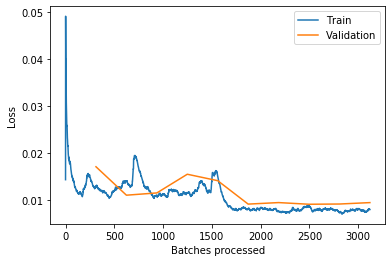

In [20]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

metrics = [
    mean_squared_error,
    mean_absolute_error
]

learn = Learner(
    model=nn.Sequential(Flatten(), nn.Linear(W * H, 1)),
    data=bunch,
    path=f"{MODEL_ROOT_DIR}/mlp",
    callback_fns=[
        partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
        partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
        partial(CSVLogger, filename=f"history_mlp")
    ],
    metrics=metrics,
    silent=False
)
learn.fit(MAX_EPOCHS)
save_stats(learn, 'mlp')
learn.save("mlp")

Epoch 5: reducing lr to 0.0006000000000000001
Epoch 4: reducing lr to 0.0006000000000000001
Epoch 3: reducing lr to 0.0006000000000000001


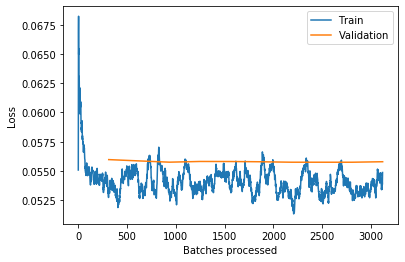

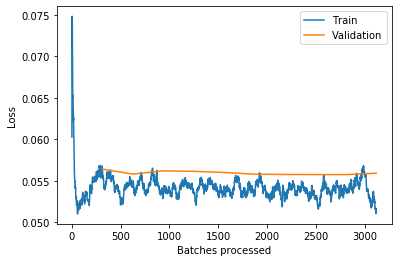

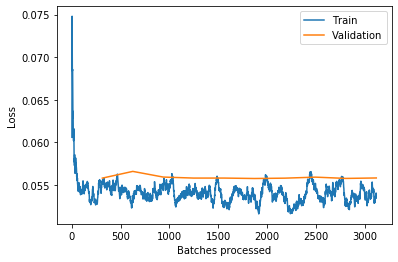

In [21]:
for model in models:
    learn = cnn_learner(
        data=bunch,
        path=path.join(MODEL_ROOT_DIR, model["name"]),
        base_arch=lambda t: model["model"],
        cut=lambda x: x,
        loss_func=loss_func,
        callback_fns=[
            partial(EarlyStoppingCallback, patience=EARLY_STOP_PATIENCE), 
            partial(ReduceLROnPlateauCallback, patience=REDUCE_ON_PLATEAU_PATIENCE),
            partial(CSVLogger, filename=f"history_{model['name']}")
        ],
        metrics=metrics,
        silent=True
    )
    learn.fit(MAX_EPOCHS)
    save_stats(learn, model["name"])
    learn.save(model["name"])

In [ ]:
summarize_results([*models, {"name":"mlp"}], MODEL_ROOT_DIR)